In [1]:
from datetime import datetime, timedelta
import calendar
import requests
from textblob import TextBlob

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [2]:
before = 10



yesterday = datetime.now() - timedelta(days=1) - timedelta(days=before)
date_for_news_u = yesterday.strftime("%Y-%m-%d")
date_for_news_l = (yesterday - timedelta(days=9)).strftime("%Y-%m-%d")
# print(date_for_news_u, date_for_news_l)


date_for_coin = datetime.utcnow() - timedelta(days=before)
date_c_u = date_for_coin.date()
date_c_l = date_for_coin.date()

date_for_coin_u = date_c_u.strftime("%d-%m-%Y %H:%M:%S")
date_for_coin_l = date_c_l.strftime("%d-%m-%Y %H:%M:%S")

date_for_coin_u = datetime.strptime(date_for_coin_u, "%d-%m-%Y %H:%M:%S") + timedelta(hours=1)
date_for_coin_l = datetime.strptime(date_for_coin_l, "%d-%m-%Y %H:%M:%S") - timedelta(days=10)

# print(date_for_coin_u, date_for_coin_l)
date_for_coin_u = calendar.timegm(date_for_coin_u.utctimetuple())-1
date_for_coin_l = calendar.timegm(date_for_coin_l.utctimetuple())
# date_for_coin_u, date_for_coin_l

news data

In [3]:
date_for_news_l, date_for_news_u, date_for_coin_l, date_for_coin_u

('2023-12-06', '2023-12-15', 1701820800, 1702688399)

In [4]:
url = ('https://newsapi.org/v2/everything?'
       'q=bitcoin+investment&'
       f'from={date_for_news_l}&'
       f'to={date_for_news_u}&'
       'sortBy=popularity&'
       'apiKey=abb843aff2e648ccb76d00bd7d7ccb67')

response = requests.get(url)

news_data = response.json()

In [5]:
len(news_data)

3

In [43]:
data = news_data['articles']
texts = []
dates = []

for article in data:
    if article['description'] is None:
        article['description'] = ''
    overall_text = article['title'] + article['description'] + article['content']
    date = article['publishedAt'][:10]
    date = datetime.strptime(date, "%Y-%m-%d")

    texts.append(overall_text)
    dates.append(date)

df_news = pd.DataFrame({"text": texts, "date": dates})

In [44]:
df_news

,text,date
0,Bitcoin price surges by 175% amid US ETF hopes...,2023-12-06
1,El Salvador Bitcoin bonds clear regulatory hur...,2023-12-12
2,Is El Salvador's crypto push working? Experts ...,2023-12-13
3,Coinbase targets financially vulnerable young ...,2023-12-14
4,5 ‘90s Icons Who Have Not Had a Great Year2023...,2023-12-07
...,...,...
95,Sam Altman-linked Meanwhile Advisors creates B...,2023-12-07
96,BTC price clears $41K as Bitcoin digests US ma...,2023-12-13
97,Bitcoin bulls eye BTC price comeback as cash i...,2023-12-14
98,Bitcoin whales aim to reclaim $42K after BTC p...,2023-12-15


In [45]:
df_news = df_news.sort_values(by=['date']).reset_index(drop=True)

In [46]:
# df_news[df_news["text"] == "[Removed][Removed][Removed]"]
df_news = df_news[~(df_news["text"] == "[Removed][Removed][Removed]")]

In [47]:
df_news['sentiment'] = df_news['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# df_news.head()

In [48]:
df_news['sentiment'] = df_news['sentiment'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# df_news

In [49]:
df_news_new = pd.DataFrame(df_news.groupby('date')['sentiment'].mean()).reset_index()

In [50]:
date_for_coin_l, date_for_coin_u

(1701820800, 1702688399)

In [51]:
url = f'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from={date_for_coin_l}&to={date_for_coin_u}'

response = requests.get(url)

coin_data = response.json()

In [52]:
# coin_data['prices'].pop(125)

In [53]:
data_crypto = coin_data['prices']
# len(data_crypto)

In [54]:
data_crypto = pd.DataFrame(data_crypto, columns=['date', 'price'])
# data_crypto.drop('date', axis=1, inplace=True)
data_crypto['date'] = data_crypto['date'].apply(lambda x: datetime.utcfromtimestamp(x / 1000)).values
# data_crypto

In [55]:
data_crypto['dummy_date'] = data_crypto['date'].apply(lambda x: x.date())
# data_crypto

In [56]:
df_news_new['dummy_date'] = df_news_new['date'].apply(lambda x: x.date())

In [57]:
# data_crypto['dummy_date'].values

In [58]:
# df_news_new

In [59]:
data_crypto_with_sent = data_crypto.join(other=df_news_new.set_index('dummy_date'), on='dummy_date', how='left', rsuffix='_news')


In [60]:
d = data_crypto_with_sent[['price', 'sentiment']]

In [61]:
data_crypto_with_sent.isnull().sum()

date          0
price         0
dummy_date    0
date_news     1
sentiment     1
dtype: int64

In [62]:
d['sentiment'][239] = d['sentiment'][238]
# d

C:\Users\shrey\AppData\Local\Temp\ipykernel_16584\1721027733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['sentiment'][239] = d['sentiment'][238]


In [63]:
model = load_model('model.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 240, 478)          462704    
_________________________________________________________________
dropout_2 (Dropout)          (None, 240, 478)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 240, 478)          1372816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 240, 478)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 478)               1372816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 478)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [64]:
d['sentiment'][d.isnull()['sentiment'] == True] = 0

C:\Users\shrey\AppData\Local\Temp\ipykernel_16584\1366223278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['sentiment'][d.isnull()['sentiment'] == True] = 0


In [65]:
a = d.values
mm = MinMaxScaler()
feat = mm.fit_transform(a[:,0].reshape(-1,1))
l = []
for i in range(len(feat)):
    l.append([feat[i][0], a[i,1]])
a = l

days = 15

pred = []
a = np.array(a)
for i in range(days * 24):
    x = model.predict(a[i:].reshape(1,a[i:].shape[0], a[i:].shape[1]))
    # print(x[0][0])
    a = np.append(a, [[x[0][0], 0]], axis=0)
    pred.append(x[0][0])

In [66]:
# model.predict(a.reshape(1,a.shape[0], a.shape[1]))

    # prev.append(a.pop(0))
# a


In [67]:
import matplotlib.pyplot as plt
# plt.plot(a[:240])
a = mm.inverse_transform(a[:,0].reshape(-1,1))
pred = mm.inverse_transform(np.array(pred).reshape(-1,1))

In [68]:
pred

array([[41910.07 ],
       [41922.383],
       [41961.094],
       [41987.008],
       [42005.637],
       [42010.77 ],
       [42025.188],
       [42053.887],
       [42080.297],
       [42104.71 ],
       [42115.52 ],
       [42132.465],
       [42167.176],
       [42207.562],
       [42231.59 ],
       [42241.414],
       [42261.293],
       [42284.004],
       [42314.13 ],
       [42342.297],
       [42370.07 ],
       [42384.6  ],
       [42397.848],
       [42421.53 ],
       [42438.75 ],
       [42464.21 ],
       [42485.06 ],
       [42503.79 ],
       [42530.062],
       [42549.02 ],
       [42571.55 ],
       [42594.266],
       [42612.97 ],
       [42631.027],
       [42645.96 ],
       [42652.91 ],
       [42654.348],
       [42660.152],
       [42679.06 ],
       [42717.05 ],
       [42730.7  ],
       [42736.945],
       [42749.977],
       [42754.207],
       [42772.39 ],
       [42780.58 ],
       [42783.484],
       [42799.977],
       [42812.906],
       [42825.71 ],


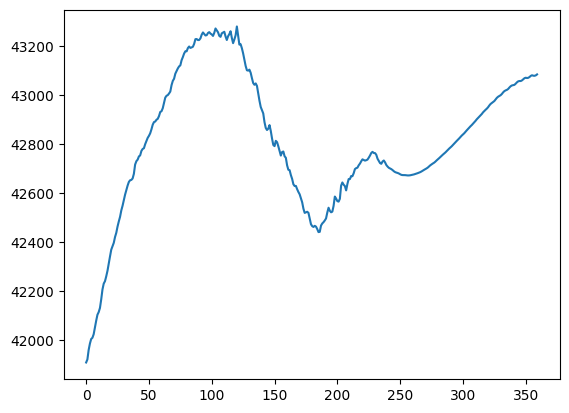

In [69]:
plt.plot(pred)

In [70]:
import seaborn as sns

In [71]:
# np.arange(1, 25, 25/600).shape
a = a[:,0]

In [78]:
# need 601 values between range 1 and 25
r = np.linspace(-20, 5, 601)
len(r)

601

<Axes: >

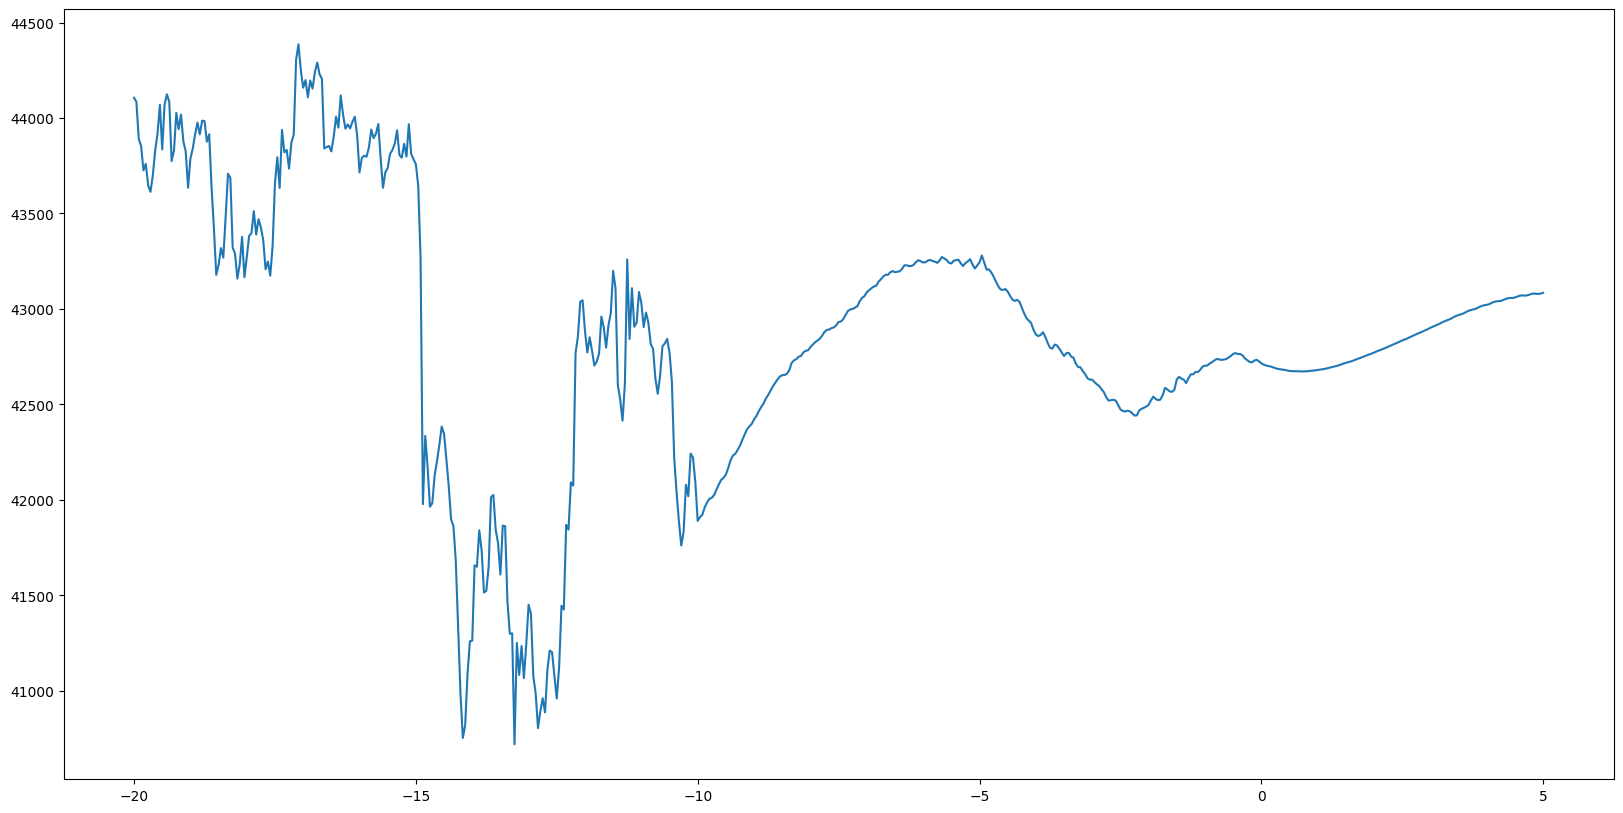

In [79]:
plt.rcParams['figure.figsize'] = (20,10)
sns.lineplot(y = a, x = r)
# plt.plot(np.arange(0,240),a[:240], color='blue')
# plt.plot(np.arange(240,288),a[240:], color='red')

# plt.plot(a[240:], label='predictions',color='red')